## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: 	Fri Feb 7, 2020 1:30pm – 2:30pm (MST)
* Instructor name: James Irving, Ph.D.
* Blog post URL: TBD

# Aim

For this project, we attempt to use existing data to predict how chess matches might end, given such variables as the type of opening, game length, and the ratings of the players. The possible endings, underneath the column `victory_status`, are checkmate, resignation, draw, and timeout. 

Due to having four classes, random guessing leads to an overall accuracy rating of 25%. We should then pick models that have an overall accuracy rating that is higher than this, and we should be sure to take into account model runtime as well.

# Importing, Exploration, and Preprocessing

First, we import relevant packages, as well as the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (precision_score, recall_score, 
                             accuracy_score, f1_score)

from imblearn.over_sampling import ADASYN,SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,RandomForestClassifier,
                              BaggingClassifier,GradientBoostingClassifier,
                              ExtraTreesClassifier)

from xgboost import XGBClassifier,XGBRFClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('games.csv')
df.head()

id  rated       created_at     last_move_at  turns victory_status  \
0  TZJHLljE  False 1504210000000.00 1504210000000.00     13      outoftime   
1  l1NXvwaE   True 1504130000000.00 1504130000000.00     16         resign   
2  mIICvQHh   True 1504130000000.00 1504130000000.00     61           mate   
3  kWKvrqYL   True 1504110000000.00 1504110000000.00     61           mate   
4  9tXo1AUZ   True 1504030000000.00 1504030000000.00     95           mate   

  winner increment_code       white_id  white_rating      black_id  \
0  white           15+2       bourgris          1500          a-00   
1  black           5+10           a-00          1322     skinnerua   
2  white           5+10         ischia          1496          a-00   
3  white           20+0  daniamurashov          1439  adivanov2009   
4  white           30+3      nik221107          1523  adivanov2009   

   black_rating                                              moves  \
0          1191  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...   
1          1261  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...   
2          1500  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...   
3          1454  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...   
4          1469  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...   

  opening_eco                            opening_name  opening_ply  
0         D10        Slav Defense: Exchange Variation            5  
1         B00  Nimzowitsch Defense: Kennedy Variation            4  
2         C20   King's Pawn Game: Leonardis Variation            3  
3         D02  Queen's Pawn Game: Zukertort Variation            3  
4         C41                        Philidor Defense            5

To reiterate (or perhaps as proof), the target column contains four unique values, and the data is whole and complete.

In [2]:
df.victory_status.unique()

array(['outoftime', 'resign', 'mate', 'draw'], dtype=object)

In [3]:
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

The range of rankings of players in this dataset is very large, going from fairly low-ranked games (~800 ranking) to very high-level games (>2700). For reference, the lowest possible ranking is 100, and the highest possible ranking is, in theory, 3000. The current highest-ranked player in the world, Magnus Carlsen, is ranked 2845. 

In [4]:
print(df['white_rating'].min(), df['white_rating'].max())
print(df['black_rating'].min(), df['black_rating'].max())

784 2700
789 2723


## Dropping Features

As there is sufficient information contained in the columns regarding the opening moves, and due to the task of processing the data within `moves`, the decision was made to remove that column entirely, opting to use the opening of the match as any indication of moves taken within the game.

Additionally, there is next to no information within the `created_at` and `last_move_at` columns, as the source of the data truncated the last (and arguably most important) 7 digits of the time values. Those columns should be removed as well.

Finally, the `id` should be dropped, as it also offers no valuable information.

In [5]:
df.drop(['moves','created_at','last_move_at','id'], axis=1, inplace=True)

In [6]:
df.head()

rated  turns victory_status winner increment_code       white_id  \
0  False     13      outoftime  white           15+2       bourgris   
1   True     16         resign  black           5+10           a-00   
2   True     61           mate  white           5+10         ischia   
3   True     61           mate  white           20+0  daniamurashov   
4   True     95           mate  white           30+3      nik221107   

   white_rating      black_id  black_rating opening_eco  \
0          1500          a-00          1191         D10   
1          1322     skinnerua          1261         B00   
2          1496          a-00          1500         C20   
3          1439  adivanov2009          1454         D02   
4          1523  adivanov2009          1469         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 12 columns):
rated             20058 non-null bool
turns             20058 non-null int64
victory_status    20058 non-null object
winner            20058 non-null object
increment_code    20058 non-null object
white_id          20058 non-null object
white_rating      20058 non-null int64
black_id          20058 non-null object
black_rating      20058 non-null int64
opening_eco       20058 non-null object
opening_name      20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), int64(4), object(7)
memory usage: 1.7+ MB


## How Many Features Are There?

Next, we should get a feel for the dimensionality of our data, should we choose to one-hot encode it as is. 

In [8]:
total_cols = 0
for col in ['opening_eco','opening_name','opening_ply','white_id','black_id','increment_code']:
    total_cols += df[col].nunique()

total_cols

21034

One-hot encoding our categorical data as is would result in an increase in dimensionality of 21,034. Clearly we must pare this down to not only keep our interpretability high, but to keep our computational costs manageable. Additionally, given the former, let's hold off on using Principal Component Analysis until we've further explored the data.

Instead, let's try dropping a few columns that play no clear role in the classification models we'll use down the road.

In [9]:
df.drop(['white_id','black_id','opening_name'], axis=1, inplace=True)
df.head()

rated  turns victory_status winner increment_code  white_rating  \
0  False     13      outoftime  white           15+2          1500   
1   True     16         resign  black           5+10          1322   
2   True     61           mate  white           5+10          1496   
3   True     61           mate  white           20+0          1439   
4   True     95           mate  white           30+3          1523   

   black_rating opening_eco  opening_ply  
0          1191         D10            5  
1          1261         B00            4  
2          1500         C20            3  
3          1454         D02            3  
4          1469         C41            5

Next we'll bin our `opening_eco` column by the letter category.

In [10]:
df['eco_category'] = df.apply(lambda row: row['opening_eco'][0], axis=1)
df.drop('opening_eco', axis=1, inplace=True)
df.head()

rated  turns victory_status winner increment_code  white_rating  \
0  False     13      outoftime  white           15+2          1500   
1   True     16         resign  black           5+10          1322   
2   True     61           mate  white           5+10          1496   
3   True     61           mate  white           20+0          1439   
4   True     95           mate  white           30+3          1523   

   black_rating  opening_ply eco_category  
0          1191            5            D  
1          1261            4            B  
2          1500            3            C  
3          1454            3            D  
4          1469            5            C

While we're at it, we should map our target column to numerical values. We'll do this by order of decreasing appearance within the dataset.

In [11]:
df['victory_status'].value_counts(normalize=True)

resign      0.56
mate        0.32
outoftime   0.08
draw        0.05
Name: victory_status, dtype: float64

In [12]:
victory_map = {
    "resign": 0,
    "mate": 1,
    "outoftime": 2,
    "draw": 3
    }

df['victory_status'] = df['victory_status'].map(victory_map)
df.head()

rated  turns  victory_status winner increment_code  white_rating  \
0  False     13               2  white           15+2          1500   
1   True     16               0  black           5+10          1322   
2   True     61               1  white           5+10          1496   
3   True     61               1  white           20+0          1439   
4   True     95               1  white           30+3          1523   

   black_rating  opening_ply eco_category  
0          1191            5            D  
1          1261            4            B  
2          1500            3            C  
3          1454            3            D  
4          1469            5            C

## Class Imbalance

While we're here, let's take a moment to understand our class imbalance issue. Random guessing, as stated before, gives an overall accuracy of 25%. "Weighted guessing"--that is, putting 56% of our guesses in class 0, 32% of our guesses in class 1, and so on--gives an overall accuracy of 42.5%. We should then instead look for models that surpass this accuracy. 

Due to the extremely low occurrence of the `outoftime` status, we would expect that to be difficult to predict, despite the existence of SMOTE. However, we don't have this problem with the `draw` category, as our `winner` column contains whether or not the match ended in a draw. Drawing upon the data given in one ending column to predict the data in another ending column, especially in such a literal way, might seem like a tautology. That is because it is. As such, we can expect perfect, or near-perfect, prediction of class 3. However, we'll be temporarily removing this feature from our data when we run our models, just to illustrate the difference.

## More Data Cleanup and One-Hot Encoding

Let's take care of the rest of the categorical column preprocessing before we one-hot encode them. We'll change `rated` from boolean to binary, and  change `increment_code` to display the starting time on the player clocks. After that, we'll be ready to encode our columns.

In [13]:
rated_map = {False: 0, True: 1}

df['rated'] = df['rated'].map(rated_map)
df.head()

rated  turns  victory_status winner increment_code  white_rating  \
0      0     13               2  white           15+2          1500   
1      1     16               0  black           5+10          1322   
2      1     61               1  white           5+10          1496   
3      1     61               1  white           20+0          1439   
4      1     95               1  white           30+3          1523   

   black_rating  opening_ply eco_category  
0          1191            5            D  
1          1261            4            B  
2          1500            3            C  
3          1454            3            D  
4          1469            5            C

In [14]:
df['game_time'] = df.apply(lambda row: row['increment_code'].split('+')[0], axis=1)
df['game_time'] = df['game_time'].astype('int64')
df.drop('increment_code', axis=1, inplace=True)
df.head()

rated  turns  victory_status winner  white_rating  black_rating  \
0      0     13               2  white          1500          1191   
1      1     16               0  black          1322          1261   
2      1     61               1  white          1496          1500   
3      1     61               1  white          1439          1454   
4      1     95               1  white          1523          1469   

   opening_ply eco_category  game_time  
0            5            D         15  
1            4            B          5  
2            3            C          5  
3            3            D         20  
4            5            C         30

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
rated             20058 non-null int64
turns             20058 non-null int64
victory_status    20058 non-null int64
winner            20058 non-null object
white_rating      20058 non-null int64
black_rating      20058 non-null int64
opening_ply       20058 non-null int64
eco_category      20058 non-null object
game_time         20058 non-null int64
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [16]:
df = pd.get_dummies(df, columns=['winner','eco_category'])

df

rated  turns  victory_status  white_rating  black_rating  opening_ply  \
0          0     13               2          1500          1191            5   
1          1     16               0          1322          1261            4   
2          1     61               1          1496          1500            3   
3          1     61               1          1439          1454            3   
4          1     95               1          1523          1469            5   
...      ...    ...             ...           ...           ...          ...   
20053      1     24               0          1691          1220            2   
20054      1     82               1          1233          1196            2   
20055      1     35               1          1219          1286            3   
20056      1    109               0          1360          1227            4   
20057      1     78               1          1235          1339            3   

       game_time  winner_black  winner_draw  winner_white  eco_category_A  \
0             15             0            0             1               0   
1              5             1            0             0               0   
2              5             0            0             1               0   
3             20             0            0             1               0   
4             30             0            0             1               0   
...          ...           ...          ...           ...             ...   
20053         10             0            0             1               1   
20054         10             1            0             0               1   
20055         10             0            0             1               0   
20056         10             0            0             1               0   
20057         10             1            0             0               0   

       eco_category_B  eco_category_C  eco_category_D  eco_category_E  
0                   0               0               1               0  
1                   1               0               0               0  
2                   0               1               0               0  
3                   0               0               1               0  
4                   0               1               0               0  
...               ...             ...             ...             ...  
20053               0               0               0               0  
20054               0               0               0               0  
20055               0               0               1               0  
20056               1               0               0               0  
20057               0               0               1               0  

[20058 rows x 15 columns]

# Preliminary Modeling

Now that we've got our data largely in the form we want, we can begin our modeling. We'll first define some functions that will help us train and evaluate the models.

In [17]:
y = df['victory_status']
X = df.drop('victory_status', axis=1)

def train_test(df=df, drop_cols=['victory_status']):
    
    y = df['victory_status']
    X = df.drop(drop_cols, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    return X_train, X_test, y_train, y_test


def scale(df=df, drop_cols=['victory_status']):
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test(df=df, drop_cols=drop_cols)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    
    return X_train_scaled, X_test_scaled, y_train, y_test


def smote(df=df, scaled=True, verbose=False, drop_cols=['victory_status']):
    
    smote=SMOTE()
    
    if scaled:
        X_train, X_test, y_train, y_test = scale(df=df, drop_cols=drop_cols)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    else:
        X_train, X_test, y_train, y_test = train_test(df=df, drop_cols=drop_cols)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    if verbose:
        print(pd.Series(y_train).value_counts())
        print(pd.Series(y_test).value_counts())
        
    return X_train, X_test, y_train, y_test
    
    
def print_metrics(labels, preds):
    print(f"Precision Score: {precision_score(labels, preds, average=None)}")
    print(f"Recall Score: {recall_score(labels, preds, average=None)}")
    print(f"Accuracy Score: {accuracy_score(labels, preds)}")
    print(f"F1 Score: {f1_score(labels, preds, average=None)}")
    
    
def plot_importance(model,top_n=20,figsize=(10,10), drop_cols=['victory_status']):
    df_importance = pd.Series(model.feature_importances_,
                              index=df.drop(drop_cols, axis=1).columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize)
    return df_importance

## Vanilla KNN

In [18]:
X_train, X_test, y_train, y_test = scale()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

test_preds = clf.predict(X_test)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7080369607126238
0.594616151545364


In [19]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

### KNN With SMOTE

In [20]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

test_preds = clf.predict(X_test)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

3    8364
2    8364
1    8364
0    8364
dtype: int64
0    2783
1    1582
2     425
3     225
Name: victory_status, dtype: int64
0.8544356767097083
0.4945164506480558


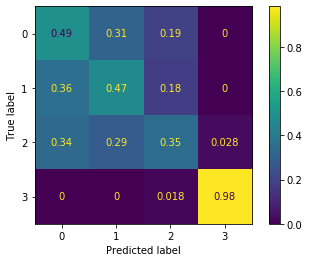

In [21]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

With SMOTE, we've gained a much higher degree of homogeneity at the cost of overall accuracy. Let's try a different model.

## Vanilla Decision Tree

In [22]:
tree = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

tree.fit(X_train, y_train)

test_preds = tree.predict(X_test)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

3    8360
2    8360
1    8360
0    8360
dtype: int64
0    2787
1    1580
2     435
3     213
Name: victory_status, dtype: int64
1.0
0.53678963110668


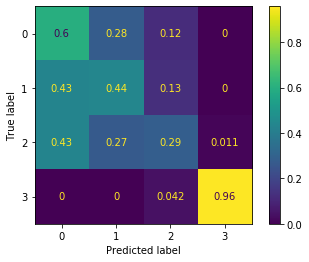

In [23]:
plot_confusion_matrix(tree, X_test, y_test, normalize='true')

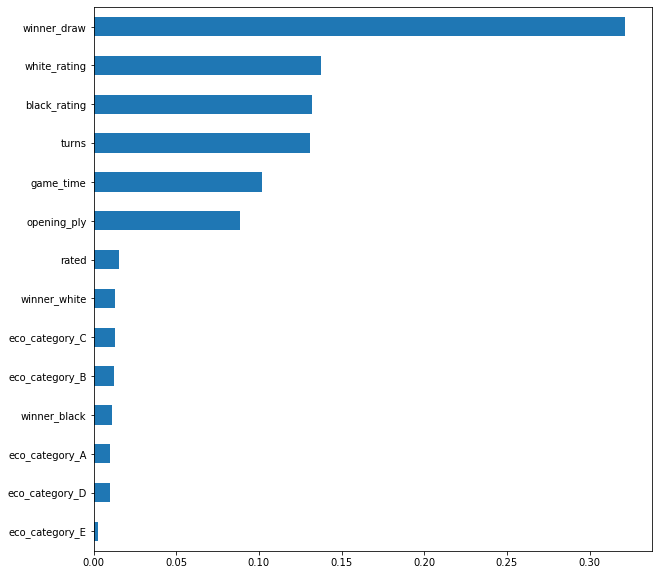

In [24]:
plot_importance(tree.fit(X_train, y_train));

### Low Depth Decision Tree

3    8419
2    8419
1    8419
0    8419
dtype: int64
0    2728
1    1610
2     444
3     233
Name: victory_status, dtype: int64
0.7217899988122105
0.5335992023928215


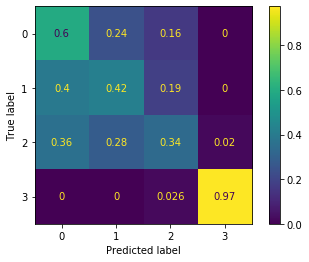

In [25]:
tree = DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True, drop_cols=['victory_status','winner_draw'])

tree.fit(X_train, y_train)

test_preds = tree.predict(X_test)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

plot_confusion_matrix(tree, X_test, y_test, normalize='true')

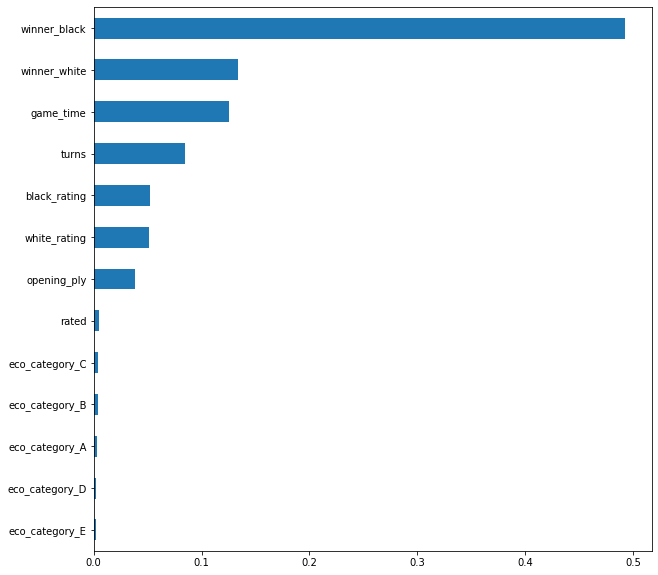

In [26]:
plot_importance(tree.fit(X_train, y_train),drop_cols=['victory_status','winner_draw']);

### Low Depth Decision Tree With Features Removed

3    8381
2    8381
1    8381
0    8381
dtype: int64
0    2766
1    1600
2     418
3     231
Name: victory_status, dtype: int64
0.6251342321918626
0.46241276171485546


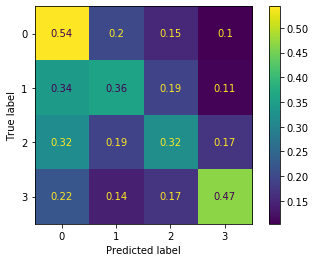

In [27]:
tree = DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True, 
                                         drop_cols=['victory_status',
                                                    'winner_draw',
                                                    'winner_black'])

tree.fit(X_train, y_train)

test_preds = tree.predict(X_test)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

plot_confusion_matrix(tree, X_test, y_test, normalize='true')

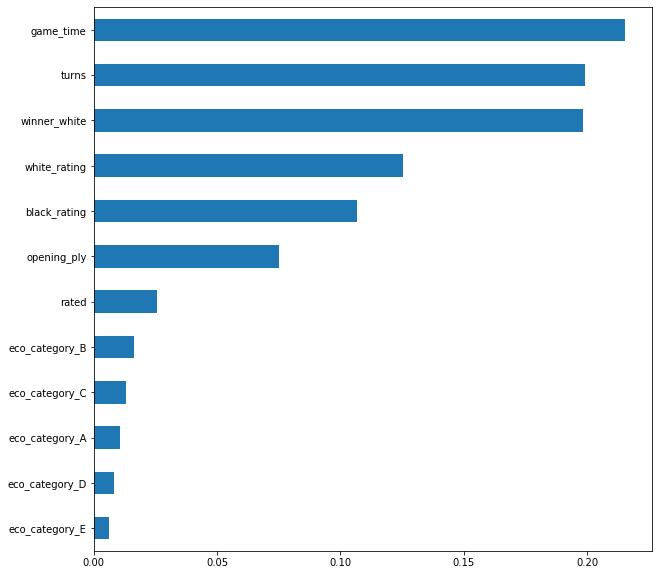

In [28]:
plot_importance(tree.fit(X_train, y_train),drop_cols=['victory_status','winner_draw','winner_black']);

## Vanilla Bagging

In [29]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

bag = BaggingClassifier(n_estimators=10)
bag.fit(X_train, y_train)
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

3    8348
2    8348
1    8348
0    8348
dtype: int64
0    2799
1    1587
2     396
3     233
Name: victory_status, dtype: int64
0.9920340201245808
0.5942173479561316


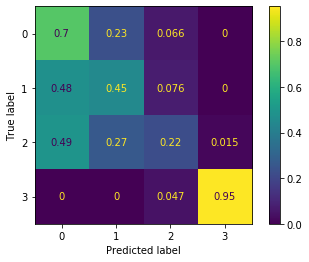

In [30]:
plot_confusion_matrix(bag, X_test, y_test, normalize='true')

## Vanilla Random Forest

In [31]:
# bootstrap aggregation is an improvement over KNN. Let's try RF
X_train, X_test, y_train, y_test = smote(scaled=False, verbose=True)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

3    8342
2    8342
1    8342
0    8342
dtype: int64
0    2805
1    1609
2     370
3     231
Name: victory_status, dtype: int64
1.0
0.6374875373878365


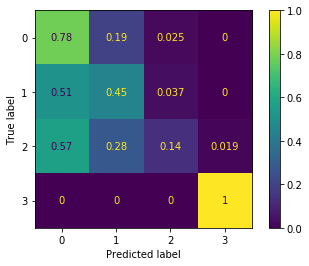

In [32]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true')

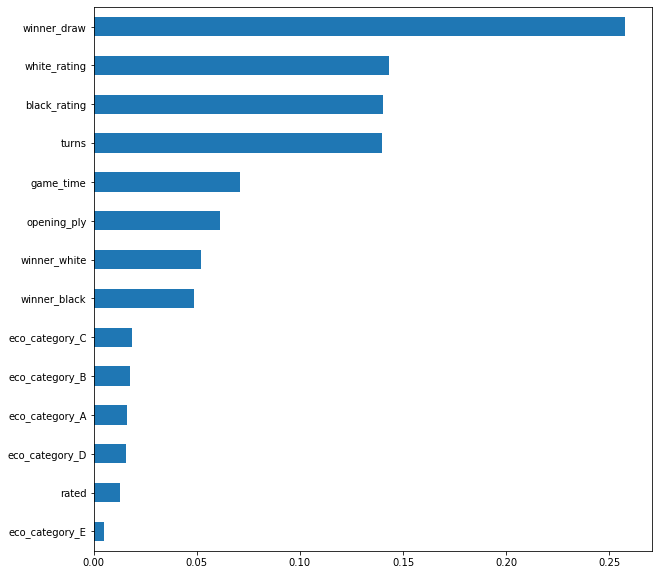

In [33]:
plot_importance(rf.fit(X_train, y_train));

### Low Depth Random Forest

In [34]:
rf = RandomForestClassifier(max_depth=10)

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.7761028530328459
0.6279162512462613


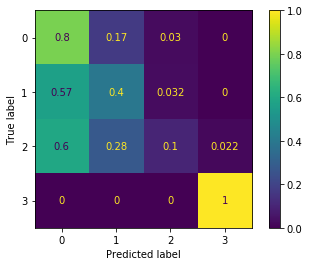

In [35]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true')

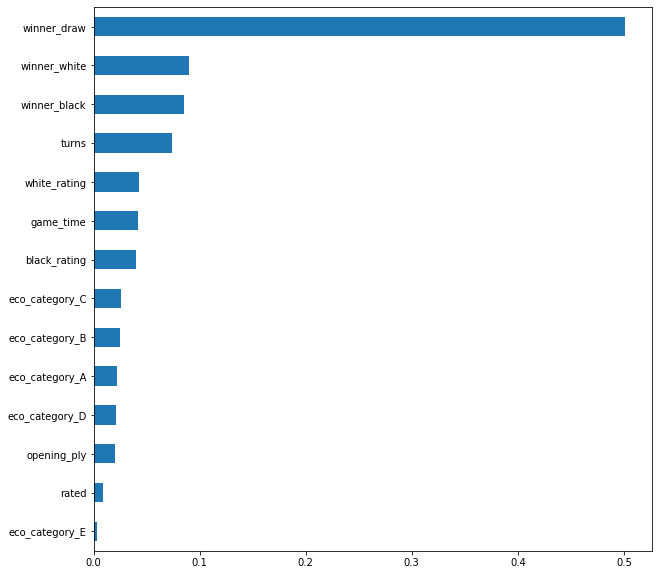

In [36]:
plot_importance(rf.fit(X_train, y_train));

### Low Depth Random Forest With Features Removed

3    8352
2    8352
1    8352
0    8352
dtype: int64
0    2795
1    1578
2     417
3     225
Name: victory_status, dtype: int64
0.7106082375478927
0.6356929212362912


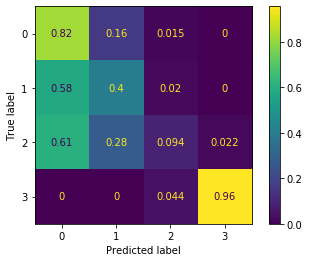

In [128]:
X_train, X_test, y_train, y_test = smote(scaled=False, verbose=True, 
                                         drop_cols=['victory_status',
                                                    'winner_draw'])

rf = RandomForestClassifier(max_depth=10)

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

plot_confusion_matrix(rf, X_test, y_test, normalize='true')

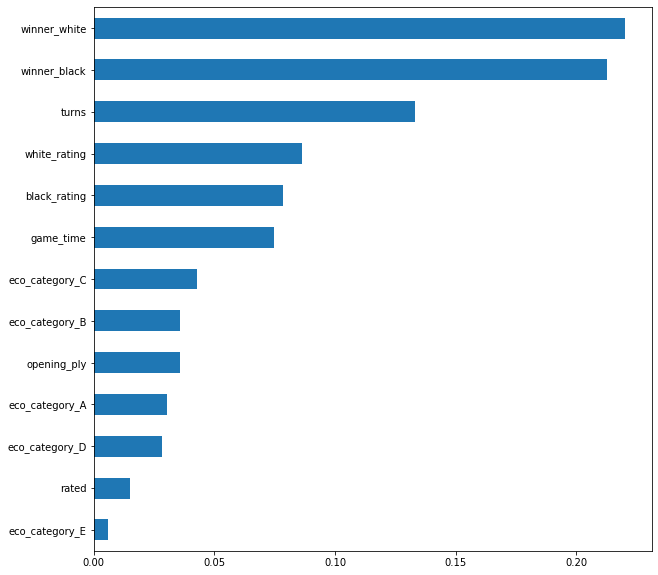

In [129]:
plot_importance(rf.fit(X_train, y_train), drop_cols=['victory_status',
                                                     'winner_draw']);

## Low Depth Extra Trees

In [39]:
X_train, X_test, y_train, y_test = smote(scaled=False, verbose=True)

et = ExtraTreesClassifier(n_estimators=100, max_depth=10)
et.fit(X_train, y_train)

print(et.score(X_train, y_train))
print(et.score(X_test, y_test))

3    8417
2    8417
1    8417
0    8417
dtype: int64
0    2730
1    1634
2     421
3     230
Name: victory_status, dtype: int64
0.7118331947249614
0.6161515453639083


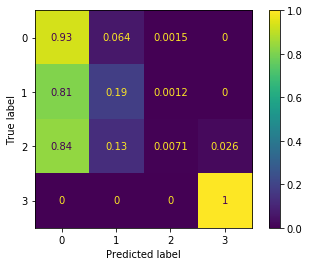

In [40]:
plot_confusion_matrix(et, X_test, y_test, normalize='true')

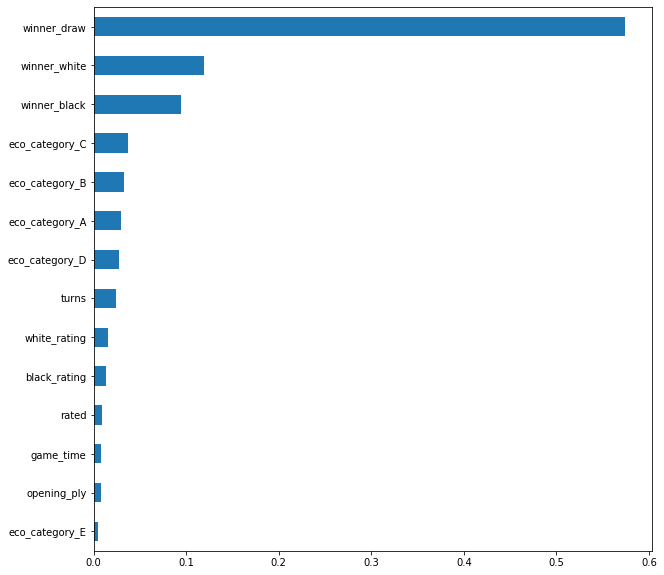

In [41]:
plot_importance(et.fit(X_train, y_train));

### Low Depth Extra Trees With Features Removed

3    8384
2    8384
1    8384
0    8384
dtype: int64
0    2763
1    1605
2     416
3     231
Name: victory_status, dtype: int64
0.5358122614503816
0.3523429710867398


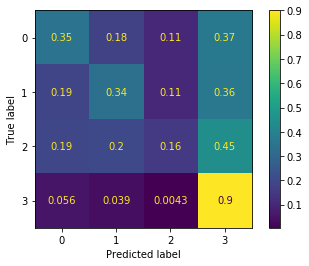

In [42]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True,
                                        drop_cols=['victory_status',
                                                     'winner_draw',
                                                     'winner_white'])

et = ExtraTreesClassifier(n_estimators=100, max_depth=10)
et.fit(X_train, y_train)

print(et.score(X_train, y_train))
print(et.score(X_test, y_test))

plot_confusion_matrix(et, X_test, y_test, normalize='true')

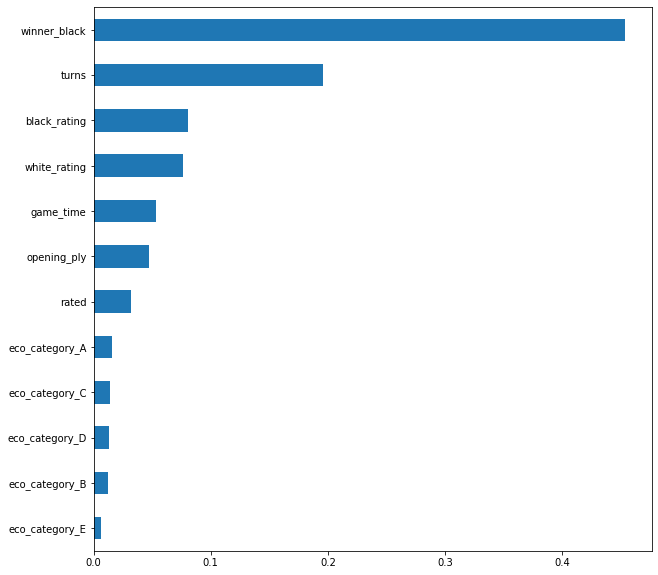

In [43]:
plot_importance(et.fit(X_train, y_train), drop_cols=['victory_status',
                                                     'winner_draw',
                                                     'winner_white']);

## Support Vector Machines

3    8384
2    8384
1    8384
0    8384
dtype: int64
0    2763
1    1569
2     429
3     254
Name: victory_status, dtype: int64
0.650793177480916
0.5046859421734795


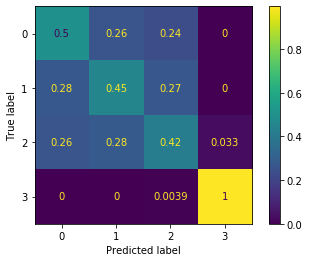

In [44]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test, normalize='true')

0.5876968034351145
0.5369890329012961
0.6365100190839694
0.5076769690927219
0.4999701812977099
0.3720837487537388


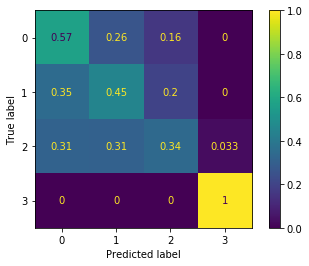

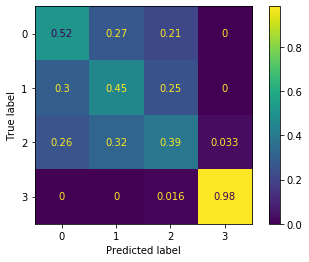

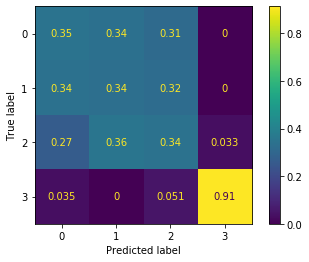

In [45]:
kernels = ['linear','poly','sigmoid']

for kernel in kernels:

    clf = SVC(gamma='auto', kernel=kernel)
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')

# Ensemble Methods

## AdaBoost With Low Depth Random Forest

3    8324
2    8324
1    8324
0    8324
dtype: int64
0    2823
1    1566
2     405
3     221
Name: victory_status, dtype: int64
0.852835175396444
0.5880358923230309


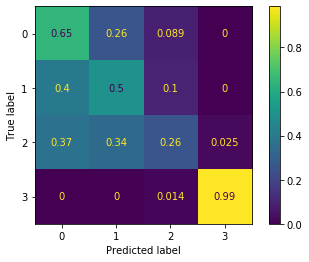

In [46]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

ada = AdaBoostClassifier(RandomForestClassifier(max_depth=10), learning_rate=0.1)
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

plot_confusion_matrix(ada, X_test, y_test, normalize='true')

## Low Depth Gradient Boost

3    8380
2    8380
1    8380
0    8380
dtype: int64
0    2767
1    1579
2     442
3     227
Name: victory_status, dtype: int64
0.9616050119331743
0.6207377866400797


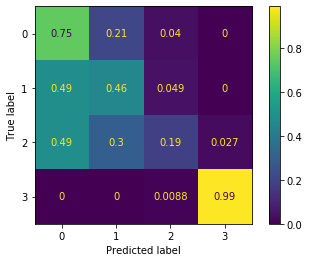

In [47]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

grad = GradientBoostingClassifier(max_depth=10)
grad.fit(X_train, y_train)
print(grad.score(X_train, y_train))
print(grad.score(X_test, y_test))

plot_confusion_matrix(grad, X_test, y_test, normalize='true')

## Vanilla XGBoost

In [63]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

xgb_rf = XGBRFClassifier()
xgb_rf.fit(X_train, y_train)
print(xgb_rf.score(X_train, y_train))
print(xgb_rf.score(X_test,y_test))

3    8378
2    8378
1    8378
0    8378
dtype: int64
0    2769
1    1579
2     431
3     236
Name: victory_status, dtype: int64
0.6142874194318453
0.481555333998006


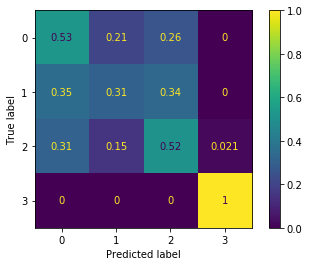

In [64]:
plot_confusion_matrix(xgb_rf, X_test, y_test, normalize='true')

### High Depth XGBoost

While a max depth of 10 is low for a regular decision tree, it is rather high for an XGBoost algorithm. We'll use that depth here.

In [49]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

xgb_rf = XGBRFClassifier(max_depth=10)
xgb_rf.fit(X_train, y_train)
print(xgb_rf.score(X_train, y_train))
print(xgb_rf.score(X_test,y_test))

3    8378
2    8378
1    8378
0    8378
dtype: int64
0    2769
1    1582
2     445
3     219
Name: victory_status, dtype: int64
0.7710670804487945
0.5824526420737787


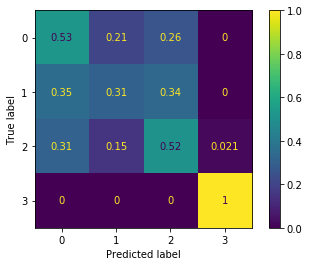

In [65]:
plot_confusion_matrix(xgb_rf, X_test, y_test, normalize='true')

rated            0.00
turns            0.02
white_rating     0.01
black_rating     0.01
opening_ply      0.01
game_time        0.02
winner_black     0.40
winner_draw      0.38
winner_white     0.14
eco_category_A   0.00
eco_category_B   0.00
eco_category_C   0.00
eco_category_D   0.00
eco_category_E   0.00
dtype: float32

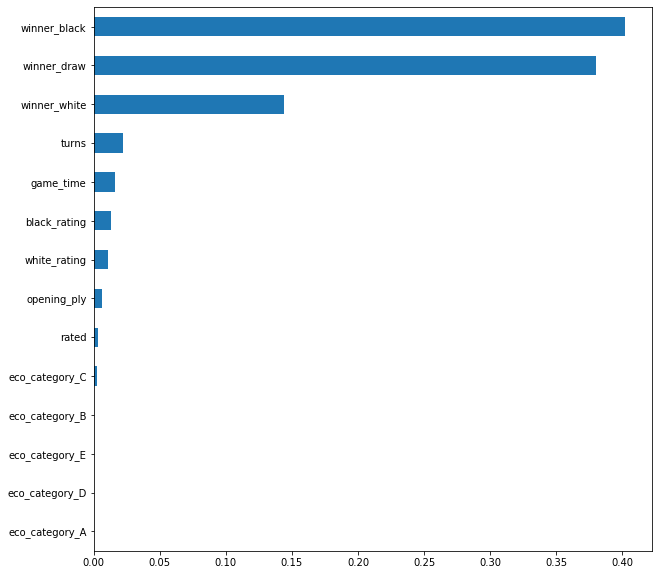

In [66]:
plot_importance(xgb_rf.fit(X_train, y_train))

### High Depth XGBoost With Feature Removed

In [125]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True, drop_cols=['victory_status',
                                                                               'winner_draw',
                                                                               'winner_black'])

xgb_rf = XGBRFClassifier(max_depth=10)
xgb_rf.fit(X_train, y_train)
print(xgb_rf.score(X_train, y_train))
print(xgb_rf.score(X_test,y_test))

3    8386
2    8386
1    8386
0    8386
dtype: int64
0    2761
1    1617
2     405
3     232
Name: victory_status, dtype: int64
0.7169091342714047
0.5106679960119641


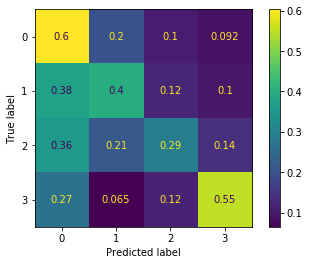

In [126]:
plot_confusion_matrix(xgb_rf, X_test, y_test, normalize='true')

In [127]:
plot_importance(xgb_rf.fit(X_train, y_train), drop_cols=['victory_status',
                                                         'winner_draw'])

ValueError: Length of passed values is 12, index implies 13

## Random Forest With Gridsearch

In [121]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

3    8385
2    8385
1    8385
0    8385
dtype: int64
0    2762
1    1583
2     432
3     238
Name: victory_status, dtype: int64


In [111]:
go_ahead = input("Cell will take several minutes to run. Do you wish to run this cell (y/n)? ")

if go_ahead == 'y':

    rf_clf = RandomForestClassifier()
    grid = {'max_depth': [1,2,5,8,10],
            'criterion': ['gini'],
            'min_samples_split':[2,5,10],
            'min_samples_leaf':[1,3,5],
            'max_features': [1,3,5,10,14]}

    gridsearch = GridSearchCV(rf_clf, param_grid=grid, cv=5)

    forest_cv = gridsearch.fit(X_train, y_train)

    print(forest_cv.best_params_)
    
else:
    
    forest_cv.best_params_ = {'criterion': 'gini', 
                              'max_depth': 10, 
                              'max_features': 3, 
                              'min_samples_leaf': 1, 
                              'min_samples_split': 2}
    
print(forest_cv.best_params_)

Cell will take several minutes to run. Do you wish to run this cell (y/n)? no
{'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [122]:
forest = RandomForestClassifier(**forest_cv.best_params_)
forest.fit(X_train, y_train)

print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.7615384615384615
0.5491525423728814


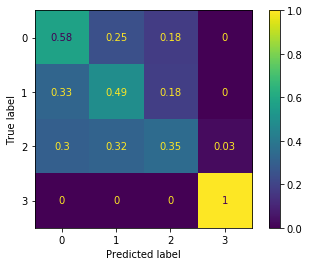

In [123]:
plot_confusion_matrix(forest, X_test, y_test, normalize='true')

rated            0.01
turns            0.09
white_rating     0.05
black_rating     0.05
opening_ply      0.04
game_time        0.07
winner_black     0.14
winner_draw      0.42
winner_white     0.12
eco_category_A   0.00
eco_category_B   0.00
eco_category_C   0.00
eco_category_D   0.00
eco_category_E   0.00
dtype: float64

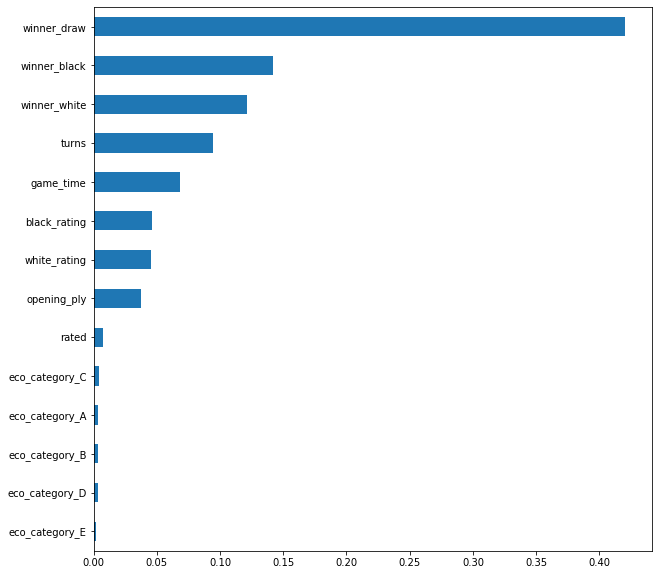

In [124]:
plot_importance(forest.fit(X_train, y_train), drop_cols=['victory_status'])

### Gridsearched Random Forest With Features Removed

In [117]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True, 
                                         drop_cols=['victory_status',
                                                    'winner_draw',
                                                    'winner_black'])

forest = RandomForestClassifier(**forest_cv.best_params_)
forest.fit(X_train, y_train)

print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

3    8361
2    8361
1    8361
0    8361
dtype: int64
0    2786
1    1597
2     427
3     205
Name: victory_status, dtype: int64
0.7046704939600527
0.4929212362911266


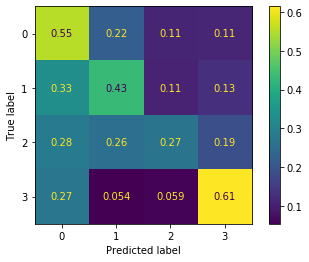

In [118]:
plot_confusion_matrix(forest, X_test, y_test, normalize='true')

rated            0.02
turns            0.21
white_rating     0.12
black_rating     0.11
opening_ply      0.09
game_time        0.17
winner_white     0.23
eco_category_A   0.01
eco_category_B   0.01
eco_category_C   0.01
eco_category_D   0.01
eco_category_E   0.01
dtype: float64

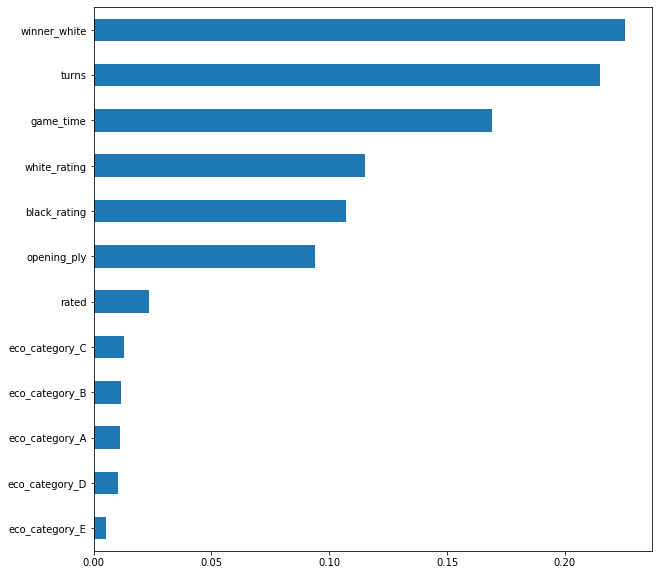

In [119]:
plot_importance(forest.fit(X_train, y_train), drop_cols=['victory_status',
                                                         'winner_draw',
                                                         'winner_black'])

It's interesting to note that despite dropping two `winner` columns, we were still able to predict draws with 60% accuracy. Let's see what a single tree looks like with these columns removed.

### Single Tree With Gridsearch Parameters

In [105]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True, 
                                         drop_cols=['victory_status',
                                                    'winner_draw',
                                                    'winner_black'])

tree = DecisionTreeClassifier(**forest_cv.best_params_)

tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

3    8328
2    8328
1    8328
0    8328
dtype: int64
0    2819
1    1536
2     435
3     225
Name: victory_status, dtype: int64
0.5724363592699327
0.4081754735792622


In [95]:
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X.drop(['winner_draw',
                                                'winner_black'], axis=1).columns,  
                           class_names=y.unique().astype('str'), 
                           filled=True, rounded=True, special_characters=True,
                           rotate=True)

graph = graph_from_dot_data(dot_data)  

Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.453234 to fit



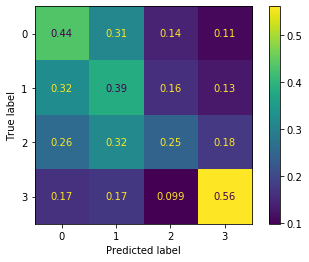

In [104]:
plot_confusion_matrix(tree, X_test, y_test, normalize='true')

# Which Model is Best?

After running what seems like a dozen or more models, the next task is to choose the best one. Judging by raw accuracy, this seems to be the Low Depth Random Forest; this is strange, considering we ran a gridsearch to determine a set of values that performed worse than the default settings. High Depth XGBoost is also a front-runner, especially given its high accuracy-to-runtime ratio. 

The attribute that all these models have in common is an accuracy "ceiling" of around 64%. It's possible we might be able to edge over that with enough hyperparameter tuning, but it might also be literally impossible to get higher accuracy with the data we have at our disposal. We should consider that 60% accuracy is over twice as good as random guessing, and with this motivation, we should then pick models that have as little overfitting as possible, i.e. models that predict both training data and testing data with accuracy as close to 60% accuracy as possible. For these reasons, it is in our best interest to select the Low Depth Random Forest model. It has the highest overall accuracy rating, while still having an acceptable amount of overfitting and runtime.

# Conclusion

Using a Low Depth Random Forest model allows us to predict the endings of chess matches with over 60% accuracy, nearly 1.5 times as accurate as weighted guessing, and nearly 2.5 times as accurate as random guessing. 